# Mod 4 Project - Time Series Analysis

* Student name: Reuben Hough
* Student pace: full time
* Scheduled project review date/time:
* Instructor name: Ahbineet Kulkarni
* Blog post URL:

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import sys
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from numpy import random
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.stattools import adfuller
import itertools
register_matplotlib_converters()
from time import time
import math

## Defining Functions

In [2]:
# Function checks if value exists in dataframe or not.
# Mostly used in debugging
def check(df, value):
    for val in value:
        if val in df['ZipCode'].values: 
            print("\nIt exists!")
        else : 
            print("\nDoes not exist!")

In [3]:
# Function that doesn't cut off any columns
# when looking at data
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

## Reading data

In [4]:
zdf = pd.read_csv('zillow_data.csv', low_memory=False)
zdf.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
# After checking a few it seems "RegionName" is actually the zip code
# so I'll go ahead and change that
zdf.rename({'RegionName': 'ZipCode'}, axis='columns', inplace=True)

In [6]:
zdf.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 272 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    14723 non-null  int64  
 1   ZipCode     14723 non-null  int64  
 2   City        14723 non-null  object 
 3   State       14723 non-null  object 
 4   Metro       13680 non-null  object 
 5   CountyName  14723 non-null  object 
 6   SizeRank    14723 non-null  int64  
 7   1996-04     13684 non-null  float64
 8   1996-05     13684 non-null  float64
 9   1996-06     13684 non-null  float64
 10  1996-07     13684 non-null  float64
 11  1996-08     13684 non-null  float64
 12  1996-09     13684 non-null  float64
 13  1996-10     13684 non-null  float64
 14  1996-11     13684 non-null  float64
 15  1996-12     13684 non-null  float64
 16  1997-01     13684 non-null  float64
 17  1997-02     13684 non-null  float64
 18  1997-03     13684 non-null  float64
 19  1997-04     13684 non-nu

Something I had suspected, and it seems to be the case: new area codes are added over time so area codes that didn't exist in a particular month have a null value. I can get rid of them without entirely getting rid of the zip code after converting to long format.

The "Metro" column also has null values, presumably because these zip codes are far from any large city. Checking this: Mount Crested Butte, CO is in the middle of nowhere with a population of 801.

Another thing to note is that dates before mid-2014 are in float where dates after are in int, but I believe that will be fixed by converting to datetime.

In [7]:
# Zipcodes in CT, MA, ME, NH, NJ, RI, and VT start with zero
# which is missing in the data set. 
# That bothers me a little so I'm adding it back in.
zdf['ZipCode'] = zdf['ZipCode'].apply('{:0>5}'.format)

In [8]:
zdf['ZipCode'].values

array(['60657', '75070', '77494', ..., '40404', '81225', '89155'],
      dtype=object)

## Initial Data Plotting

First I'm going to take a look at modeling the data to make sure everything works properly. Unfortunately, ZipCode 10004 in Lower Manhattan where Flatiron School is located isn't in the dataset, in fact only one Zip Code from Lower Manhattan exists in the data.

In [9]:
check(zdf, ["10002", "10003", "10004", "10005", "10006","10007",
            "10009", "10012", "10013", "10014", "10280", "10282"])


Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

It exists!

Does not exist!

Does not exist!


I'm going to use the Zip Code I currently live in instead.

In [10]:
Reno = zdf.copy()
Reno = Reno[Reno.ZipCode.isin(["89509"])]

In [11]:
# This function defines a plot using the unmelted data
def Growthplot(df):
    xticks = ['1996-04', '2000-04', '2004-04', '2008-04', '2012-04', '2016-04']
    xlabels = ['1996', '2000', '2004', '2008', '2012', '2016']
    yticks = [100000, 200000, 300000, 400000, 500000, 600000, 700000]
    ylabels = ['100K', '200K', '300K', '400K', '500K', '600K', "700K"]
    plt.figure(figsize=(16,8))
    for n, index in enumerate(df.index):
        sample = df.loc[index,'1996-04':'2018-04']
        zipcode = df.loc[index]['ZipCode']
        plt.plot(sample, label=df.loc[index]['ZipCode'])
    plt.xticks(xticks, labels=xlabels)
    plt.yticks(yticks, labels=ylabels)
    plt.legend()
    plt.title('Zipcode Growth over Period 1996-2018')
    plt.ylabel('Median home price ($)')
    plt.xlabel('Year')
    plt.show();

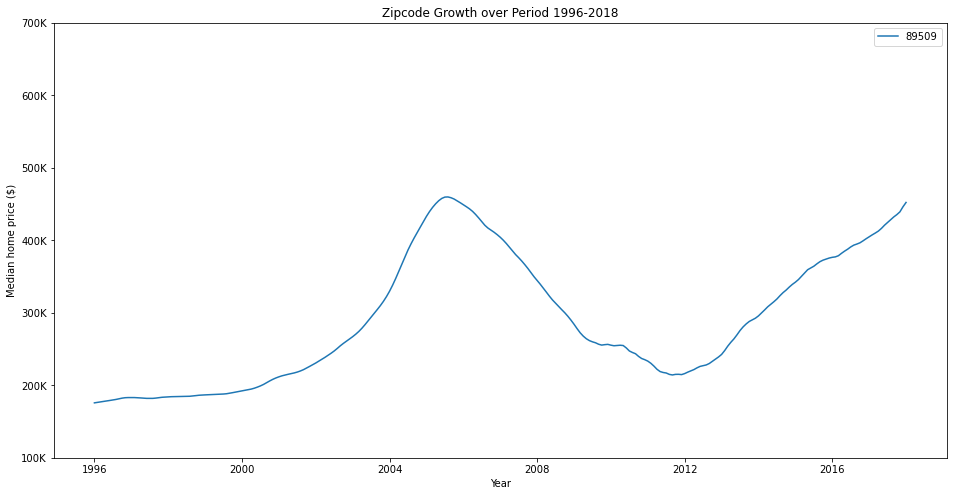

In [12]:
Growthplot(Reno)

This shows the highly variable nature of house prices. It seems that by 2018 in Reno the house prices hadn't gotten back to the level they were at a decade earlier!

This also shows the 2008 housing crisis, but by the looks of things Reno was already starting to lose steam by 2006.

Next I'll try the greater Portland Area. All of those Zip Codes exist in the data.

In [13]:
Portland = zdf.copy()
Portland = Portland[Portland.ZipCode.isin(["97009", "97019", "97034", "97035", "97055", "97056",
                                           "97080", "97124", "97202", "97206", "97219", "97221",
                                           "97222", "97229", "97231", "97236", "97266"])]

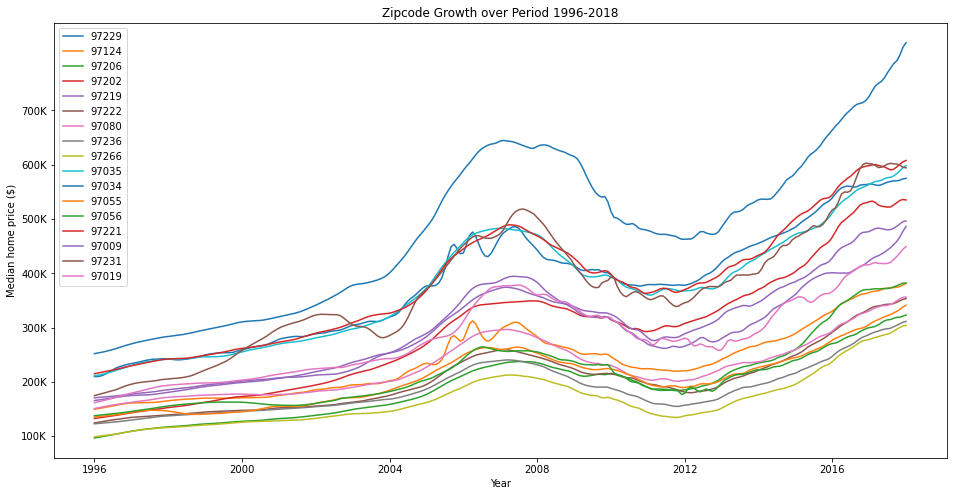

In [14]:
Growthplot(Portland)

The housing bubble is much more obvious in this graph, and Portland seems to have recovered better than Reno has.

It may be a good idea to eliminate housing prices that are prior to 2010 so that the housing crisis won't factor in, and so that I can keep more zip codes that didn't exist until then.

In [15]:
mdf = zdf.drop(zdf.loc[:, '1996-04':'2010-03'].columns, axis = 1)

## Melting Data

In [16]:
# Function for transforming data to long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','ZipCode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MedianValue')
    # Converting to datetime
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    # Dropping N/A values from months when the zip did not exist 
    melted = melted.dropna(subset=['MedianValue'])
    return melted

In [17]:
# Running function to melt dates
mdf = melt_data(mdf)
mdf.info()
mdf.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1417604 entries, 0 to 1428130
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   RegionID     1417604 non-null  int64         
 1   ZipCode      1417604 non-null  object        
 2   City         1417604 non-null  object        
 3   State        1417604 non-null  object        
 4   Metro        1317384 non-null  object        
 5   CountyName   1417604 non-null  object        
 6   SizeRank     1417604 non-null  int64         
 7   Month        1417604 non-null  datetime64[ns]
 8   MedianValue  1417604 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 108.2+ MB


(1417604, 9)

Now the dataframe has 1.4 million rows, after deleting around about 200k NaN values. A good amount of information to look through. I may have to cut down on the number of zips and limit them to a few cities or a state.

I'm not going to use a couple rows so I'll go ahead and delete them now. Also changing MedianValue column into integer values.

In [18]:
mdf.drop(['RegionID', 'SizeRank', 'Metro'], axis=1, inplace=True)
mdf.MedianValue = mdf.MedianValue.apply(lambda x: int(x))
display(mdf.head())

,ZipCode,City,State,CountyName,Month,MedianValue
0,60657,Chicago,IL,Cook,2010-04-01,767900
1,75070,McKinney,TX,Collin,2010-04-01,202700
2,77494,Katy,TX,Harris,2010-04-01,250800
3,60614,Chicago,IL,Cook,2010-04-01,977400
4,79936,El Paso,TX,El Paso,2010-04-01,116100


I'm going to limit the zipcodes to the northwest states of Washington and Oregon. I'm planning on moving to the area in the future, so a future employer would most likely have me dealing with data in the local area.

In [19]:
nws = mdf[(mdf.State.isin(['WA','OR']))].copy()
print(len(nws.ZipCode.unique()))
print(nws.isna().sum())
nws.info()

565
ZipCode        0
City           0
State          0
CountyName     0
Month          0
MedianValue    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54499 entries, 67 to 1428124
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ZipCode      54499 non-null  object        
 1   City         54499 non-null  object        
 2   State        54499 non-null  object        
 3   CountyName   54499 non-null  object        
 4   Month        54499 non-null  datetime64[ns]
 5   MedianValue  54499 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.9+ MB


In [23]:
nws.ZipCode.value_counts()[-10:]

98102    97
99324    97
97138    97
98418    97
98043    97
         ..
98282    97
97471    97
97367    97
97501    97
98225    97
Name: ZipCode, Length: 557, dtype: int64

It seems 8 zipcodes don't have all the values, they were probably added since 2008. Since there are relatively few I'll just delete those.

In [21]:
nws = nws[~nws.ZipCode.isin(["97413", "99163", "98851", "97733",
                             "97624", "97499", "97467", "97435"])]

In order to cut down the number of zipcodes, I'm going to get a basic idea about which are probably the best by dividing the last months value by the first and taking the top 40. From there I will do better calcluations